In [1]:
from pylab import *
import numpy as np
import healpy as hp
%matplotlib inline
from matplotlib import rc
rc('figure',figsize=(10,10))
rc('font',size=20)
rc('text',usetex=False)

# Map-Making in the Spectro-Imager case
This notebooks aims at showing how to build maps in the spectro-imaging case from a single TOD. It uses a simplistic library for a pipeline in the same directory called [SpectroImLib.py](./SpectroImLib.py) done just for this purpose. It does not intend to replace a pipeline that needs to be developped.

In [2]:
from __future__ import division
import sys
import healpy as hp
import numpy as np
import matplotlib.pyplot as mp
from qubic import (create_random_pointings, gal2equ,
                  read_spectra,
                  compute_freq,
                  QubicScene,
                  QubicMultibandInstrument,
                  QubicMultibandAcquisition,
                  PlanckAcquisition,
                  QubicMultibandPlanckAcquisition)
import qubic
import SpectroImLib as si
from pysimulators import FitsArray

/Users/hamilton/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


ImportError: cannot import name _flib

In the following we define the default configuration for this test, parameters can easily be changed...

In [ ]:
######## Default configuration
### Sky 
nside = 256
center_gal = 0, 90
center = gal2equ(center_gal[0], center_gal[1])
dust_coeff = 1.39e-2

### Detectors (for now using random pointing)
band = 150
relative_bandwidth = 0.25
sz_ptg = 10.
nb_ptg = 1000
effective_duration = 2.
ripples = False   

### Mapmaking
tol = 1e-4

### Number of sub-bands to build the TOD
nf_sub_build = 15
nf_sub_rec = 2

parameters = {'nside':nside, 'center':center, 'dust_coeff': dust_coeff, 
				'band':band, 'relative_bandwidth':relative_bandwidth,
				'sz_ptg':sz_ptg, 'nb_ptg':nb_ptg, 'effective_duration':effective_duration, 
				'tol': tol, 'ripples':ripples,
				'nf_sub_build':nf_sub_build, 
				'nf_sub_rec': nf_sub_rec }

Most of the parameters definitions are straighforward. However it is worth explaining:
- nf_sub_build: is the number of sub-frequencies used for building the TOD. The larger the better to have a better approximation of the integral through the badwidth.
- nf_sub_rec: is the number of sub-bands for the map-making output: we project this TOD onto this number of sub-bands. Typically 1 if full bad is wanted (no spectro-imaging) or 2, 3 or 4 for spectro-imaging. Beyond 3 or 4 large fluctuations are expected because we go beyond the frequency resolution of QUBIC.

And the actual parameters are then:

In [6]:
for k in parameters.keys(): print(k, parameters[k])

('nside', 256)
('nb_ptg', 1000)
('band', 150)
('relative_bandwidth', 0.25)
('nf_sub_rec', 2)
('dust_coeff', 0.0139)
('nf_sub_build', 15)
('center', (array(192.85948000035322), array(27.128250000615303)))
('sz_ptg', 10.0)
('ripples', False)
('tol', 0.0001)
('effective_duration', 2.0)


Note that $10^{-4}$ for the mapmaking PCG tolerance might not be sufficient in realistic cases...

First let's create sky maps for each of the nf_sub_build frequencies (they include dust):

In [7]:
x0 = si.create_input_sky(parameters)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


Now a random pointing (nb_ptg pointings within a cone of sz_ptg degrees):

In [9]:
p = si.create_random_pointings(parameters['center'], 
                               parameters['nb_ptg'], parameters['sz_ptg'])

Now we create the TOD

In [10]:
TOD = si.create_TOD(parameters, p, x0)

Info jch-mac.lan: Allocating (992000,12) elements = 181.640625 MiB in FSRRotation3dMatrix.__init__.
Info jch-mac.lan: Allocating (992000,12) elements = 181.640625 MiB in FSRRotation3dMatrix.__init__.
Info jch-mac.lan: Allocating (992000,12) elements = 181.640625 MiB in FSRRotation3dMatrix.__init__.
Info jch-mac.lan: Allocating (992000,12) elements = 181.640625 MiB in FSRRotation3dMatrix.__init__.
Info jch-mac.lan: Allocating (992000,13) elements = 196.77734375 MiB in FSRRotation3dMatrix.__init__.
Info jch-mac.lan: Allocating (992000,13) elements = 196.77734375 MiB in FSRRotation3dMatrix.__init__.
Info jch-mac.lan: Allocating (992000,13) elements = 196.77734375 MiB in FSRRotation3dMatrix.__init__.
Info jch-mac.lan: Allocating (992000,13) elements = 196.77734375 MiB in FSRRotation3dMatrix.__init__.
Info jch-mac.lan: Allocating (992000,14) elements = 211.9140625 MiB in FSRRotation3dMatrix.__init__.
Info jch-mac.lan: Allocating (992000,15) elements = 227.05078125 MiB in FSRRotation3dMatrix

We can check that there is a single TOD for each detector, as expected if all sub-frequencies have been summed-up to approximate the bandwidth integral:

In [42]:
np.shape(TOD)

(992, 1000)

And we reconstruct the nf_sub_rec maps (NB: here the reconstruct_maps() function had the input maps as a keyword, so it returns the convolved input maps at each of the nf_sub_rec frequencies into the variable maps_convolved):

In [39]:
maps_recon, coverage, nus, nus_edge, maps_convolved = si.reconstruct_maps(TOD, 
                                                                     parameters, p, 
                                                                     x0=x0)
if int(parameters['nf_sub_rec'])==1: 
    maps_recon=np.reshape(maps_recon, np.shape(maps_convolved))

Info jch-mac.lan: Allocating (992000,12) elements = 181.640625 MiB in FSRRotation3dMatrix.__init__.
Info jch-mac.lan: Allocating (992000,12) elements = 181.640625 MiB in FSRRotation3dMatrix.__init__.
Info jch-mac.lan: Allocating (992000,12) elements = 181.640625 MiB in FSRRotation3dMatrix.__init__.
Info jch-mac.lan: Allocating (992000,12) elements = 181.640625 MiB in FSRRotation3dMatrix.__init__.
Info jch-mac.lan: Allocating (992000,13) elements = 196.77734375 MiB in FSRRotation3dMatrix.__init__.
Info jch-mac.lan: Allocating (992000,13) elements = 196.77734375 MiB in FSRRotation3dMatrix.__init__.
Info jch-mac.lan: Allocating (992000,13) elements = 196.77734375 MiB in FSRRotation3dMatrix.__init__.
Info jch-mac.lan: Allocating (992000,13) elements = 196.77734375 MiB in FSRRotation3dMatrix.__init__.
Info jch-mac.lan: Allocating (992000,14) elements = 211.9140625 MiB in FSRRotation3dMatrix.__init__.
Info jch-mac.lan: Allocating (992000,15) elements = 227.05078125 MiB in FSRRotation3dMatrix

And we calculate the residual maps:

In [40]:
print(coverage.shape)
coveragetot = np.sum(coverage, axis=0)
maxcov = np.max(coveragetot)
unseen = coveragetot < maxcov*0.1
diffmap = maps_convolved - maps_recon
maps_convolved[:,unseen,:] = hp.UNSEEN
maps_recon[:,unseen,:] = hp.UNSEEN
diffmap[:,unseen,:] = hp.UNSEEN

(15, 786432)


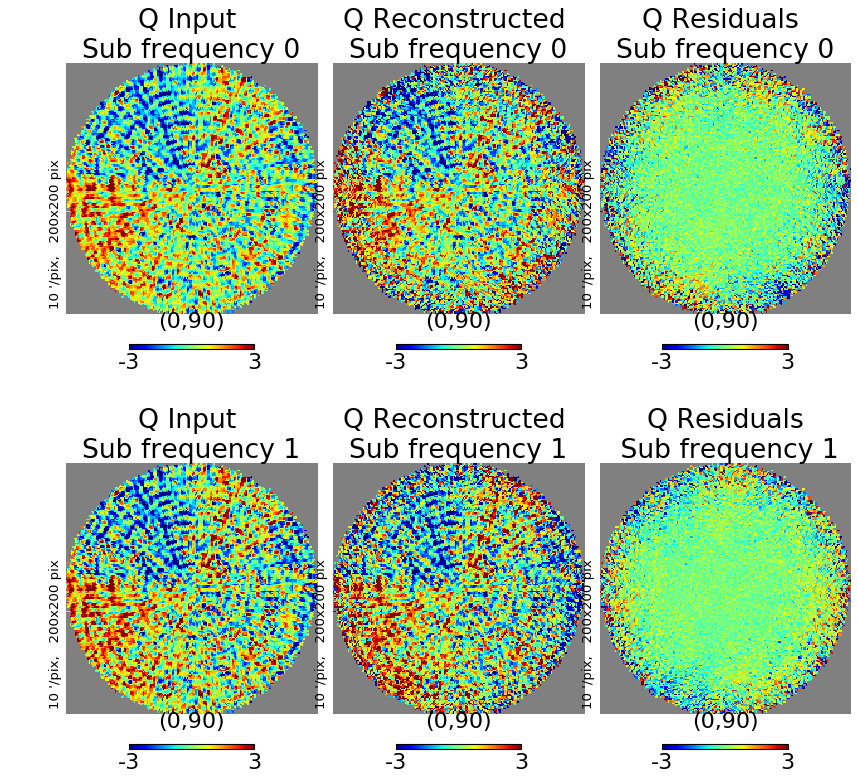

In [41]:
hp.gnomview(maps_convolved[0,:,1], rot=center_gal, reso=10, 
            min=-3, max=3, title='Q Input \nSub frequency 0', 
            sub=(2,3,1))
hp.gnomview(maps_recon[0,:,1], rot=center_gal, reso=10, 
            min=-3, max=3, title='Q Reconstructed \nSub frequency 0', 
            sub=(2,3,2))
hp.gnomview(diffmap[0,:,1], rot=center_gal, reso=10, 
            min=-3, max=3, title='Q Residuals \nSub frequency 0', 
            sub=(2,3,3))
hp.gnomview(maps_convolved[1,:,1], rot=center_gal, reso=10, 
            min=-3, max=3, title='Q Input \nSub frequency 1', 
            sub=(2,3,4))
hp.gnomview(maps_recon[1,:,1], rot=center_gal, reso=10, 
            min=-3, max=3, title='Q Reconstructed \nSub frequency 1', 
            sub=(2,3,5))
hp.gnomview(diffmap[1,:,1], rot=center_gal, reso=10, 
            min=-3, max=3, title='Q Residuals\n Sub frequency 1', 
            sub=(2,3,6))